In [1]:
import numpy as np
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Import necessary items from Keras
from keras.models import Sequential
from keras.layers import Activation, Dropout, UpSampling2D
from keras.layers import Conv2DTranspose, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def conv2d_block(input_tensor,n_filters,kernel_size=3):
  x=input_tensor
  for i in range(2):
    x=tf.keras.layers.Conv2D(filters=n_filters,kernel_size=(kernel_size,kernel_size),padding='same')(x)
    x=tf.keras.layers.Activation('relu')(x)
  return x
def encoder_block(inputs,n_filter,pool_size,dropout):
  f=conv2d_block(input_tensor=inputs,n_filters=n_filter)
  p=tf.keras.layers.MaxPooling2D(pool_size)(f)
  p=tf.keras.layers.Dropout(dropout)(p)
  return f,p
def encoder1(inputs):
  f1,p1=encoder_block(inputs,n_filter=64,pool_size=(2,2),dropout=0.3)
  f2,p2=encoder_block(p1,n_filter=128,pool_size=(2,2),dropout=0.3)
  f3,p3=encoder_block(p2,n_filter=256,pool_size=(2,2),dropout=0.3)
  f4,p4=encoder_block(p3,n_filter=512,pool_size=(2,2),dropout=0.3)
  return p4,(f1,f2,f3,f4)
def bottleneck(inputs):
  bottle_neck=conv2d_block(inputs,n_filters=1024)
  return bottle_neck
def decoder_block(inputs,conv_output,n_filter,kernel_size,strides,dropout):
  u=tf.keras.layers.Conv2DTranspose(n_filter,kernel_size,strides=strides,padding='same')(inputs)
  c=tf.keras.layers.concatenate([u,conv_output])
  c = tf.keras.layers.Dropout(dropout)(c)
  c=conv2d_block(c,n_filter,kernel_size=3)
  return c
def decoder1(inputs,convs):
  f1,f2,f3,f4=convs
  c6=decoder_block(inputs,f4,n_filter=512,kernel_size=(3,3),strides=(2,2),dropout=0.3)
  c7=decoder_block(c6,f3,n_filter=256,kernel_size=(3,3),strides=(2,2),dropout=0.3)
  c8=decoder_block(c7,f2,n_filter=128,kernel_size=(3,3),strides=(2,2),dropout=0.3)
  c9=decoder_block(c8,f1,n_filter=64,kernel_size=(3,3),strides=(2,2),dropout=0.3)
  outputs=tf.keras.layers.Conv2D(3,kernel_size=(1,1),activation='relu')(c9)
  return outputs

In [ ]:
def block(x,filters,kernel_size,activation,pool_size,strides):
    for i in range(0,3):
        x=tf.keras.layers.Conv2D(filters=filters,kernel_size=kernel_size,activation=activation,padding='same')(x)
    x=tf.keras.layers.MaxPooling2D(pool_size=pool_size,strides=strides)(x)
    x=tf.keras.layers.Dropout(0.2)(x)
    return x
def encoder(inputs):
    x=block(inputs,filters=64,kernel_size=(2,2),activation='relu',pool_size=(2,2),strides=(2,2))
    p1=x
    x=block(inputs,filters=128,kernel_size=(2,2),activation='relu',pool_size=(2,2),strides=(2,2))
    p2=x
    x=block(x,filters=256,kernel_size=(2,2),activation='relu',pool_size=(2,2),strides=(2,2))
    p3=x
    x=block(x,filters=512,kernel_size=(2,2),activation='relu',pool_size=(2,2),strides=(2,2))
    p4=x
    x=block(x,filters=512,kernel_size=(2,2),activation='relu',pool_size=(2,2),strides=(2,2))
    p5=x
    return (p3,p4,p5)
def decoder(convs):
    f3,f4,f5=convs
    o=tf.keras.layers.Conv2DTranspose(512,kernel_size=(2,2),strides=(2,2),padding='same')(f5)
    o=tf.keras.layers.Conv2D(512,(2,2),activation='relu',padding='same')(o)
    o2=f4
    o2=tf.keras.layers.Conv2D(512,(2,2),activation='relu',padding='same')(o2)
    o=tf.keras.layers.Add()([o,o2])
    o=tf.keras.layers.Conv2DTranspose(256,kernel_size=(2,2),strides=(2,2),padding='same')(o)
    o=tf.keras.layers.Conv2D(256,(2,2),activation='relu',padding='same')(o)
    o3=f3
    o3=tf.keras.layers.Conv2D(256,(2,2),activation='relu',padding='same')(o3)
    o=tf.keras.layers.Add()([o,o3])
    o4=tf.keras.layers.Conv2DTranspose(1,kernel_size=(4,4),strides=(4,4))(o)
    o=tf.keras.layers.Activation('relu')(o4)
    return o
def fcn8():
    inputs1=tf.keras.layers.Input(shape=(192,192,3,))
    encoder_output,convs=encoder1(inputs1)
    bottle_neck=bottleneck(encoder_output)
    outputs=decoder1(bottle_neck,convs)
    inputs=outputs
    convs=encoder(inputs)
    outputs=decoder(convs)
    model=tf.keras.Model(inputs=inputs1,outputs=outputs)
    return model

In [ ]:
def parse_image_function(example_proto):
    #This descibes the structure of each element in the dataset
    image_feature_description={
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        'image_raw': tf.io.FixedLenFeature([], tf.string),
        'mask_raw': tf.io.FixedLenFeature([], tf.string)
        }
    
    #The features are extracted to a dictionary
    feature=tf.io.parse_single_example(example_proto, image_feature_description)
    
    #Images and Annotations are resized to (192,192)
    image = tf.image.decode_jpeg(feature['image_raw'])
    image = tf.cast(image, tf.float32) / 255.0
    annotation = tf.image.decode_png(feature['mask_raw'], channels=1)
    annotation = tf.cast(annotation, tf.float32) / 1.0
    
    image = tf.reshape(image, (360,640,3))
    annotation = tf.reshape(annotation, (360,640,1))
    
    image = tf.image.pad_to_bounding_box(image, 140, 0, 640, 640)
    annotation = tf.image.pad_to_bounding_box(annotation, 140, 0, 640, 640)
    
    image = tf.image.resize(image, size=(192,192))
    annotation = tf.image.resize(annotation, size=(192,192))
    
    #Randomly flips images and annotations
    if(random.random() > 0.5):
        image = tf.image.flip_left_right(image)
        annotation = tf.image.flip_left_right(annotation)
    
    return image, annotation

In [ ]:
import random
import math
train_dataset = tf.data.TFRecordDataset(['train.tfrecords'])
train_dataset = train_dataset.map(parse_image_function)
ds_train = train_dataset.shuffle(buffer_size=584)
ds_train = ds_train.repeat()
ds_train = ds_train.batch(8)
ds_train = ds_train.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.TFRecordDataset('val.tfrecords')
val_dataset = val_dataset.map(parse_image_function)
ds_val = val_dataset.shuffle(buffer_size=32)
ds_val = ds_val.repeat()
ds_val = ds_val.batch(8)
ds_val = ds_val.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
train_dataset
from tensorflow.keras.callbacks import LearningRateScheduler

In [ ]:
def step_decay(epoch):
  initial_lrate=0.001
  drop = 0.8
  epochs_drop = 2
  lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
  return lrate

#learning rate with decay dfined by above funtion
lrate = LearningRateScheduler(step_decay)

#Callback to stop training after accuracy reaches 99.5%
class myCallBack(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        try:
          if(logs.get('acc') >= 1):
              self.model.stop_training = True
        except:
          pass

callback = myCallBack()

#Final list of callbacks    
callbacks_list = [lrate, callback]

In [ ]:
def main():
  model = fcn8()
  model.compile(optimizer=tf.keras.optimizers.Adam(0.0), loss='binary_crossentropy', metrics=['accuracy'])
  model.fit(ds_train,steps_per_epoch=600//8,epochs=10, validation_data=ds_val, validation_steps=1, callbacks=callbacks_list, verbose = 1)
  model.save('model.h5')

In [ ]:
main()

Epoch 1/10
75/75 [==============================] - 53s 618ms/step - loss: 0.1161 - accuracy: 0.9733 - val_loss: 0.0998 - val_accuracy: 0.9730
Epoch 2/10
75/75 [==============================] - 47s 622ms/step - loss: 0.0860 - accuracy: 0.9758 - val_loss: 0.0755 - val_accuracy: 0.9769
Epoch 3/10
75/75 [==============================] - 47s 629ms/step - loss: 0.0798 - accuracy: 0.9758 - val_loss: 0.0806 - val_accuracy: 0.9696
Epoch 4/10
75/75 [==============================] - 48s 634ms/step - loss: 0.0530 - accuracy: 0.9793 - val_loss: 0.0521 - val_accuracy: 0.9790
Epoch 5/10
75/75 [==============================] - 48s 634ms/step - loss: 0.0870 - accuracy: 0.9767 - val_loss: 0.0760 - val_accuracy: 0.9726
Epoch 6/10
75/75 [==============================] - 48s 639ms/step - loss: 0.0519 - accuracy: 0.9802 - val_loss: 0.0535 - val_accuracy: 0.9795
Epoch 7/10
75/75 [==============================] - 48s 640ms/step - loss: 0.0508 - accuracy: 0.9803 - val_loss: 0.0479 - val_accuracy: 0.9783

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
import cv2 
image=cv2.imread('lane.jpeg')
print(image)
from tensorflow.keras.models import load_model
model = load_model('model.h5')
small_img = cv2.resize(image, (192, 192))
small_img = np.array(small_img)
small_img = small_img[None,:,:,:]
prediction = model.predict(small_img)
prediction

[[[123 128 137]
  [114 119 128]
  [110 115 124]
  ...
  [ 59 145 135]
  [ 40 126 116]
  [ 64 150 140]]

 [[120 125 134]
  [111 116 125]
  [107 112 121]
  ...
  [ 70 153 144]
  [ 51 137 127]
  [ 72 155 146]]

 [[116 121 130]
  [106 111 120]
  [103 108 117]
  ...
  [ 59 140 131]
  [ 44 127 118]
  [ 58 139 130]]

 ...

 [[ 82  91 100]
  [ 84  93 102]
  [ 86  95 104]
  ...
  [122 121 131]
  [122 121 131]
  [122 121 131]]

 [[ 79  88  97]
  [ 86  95 104]
  [ 95 104 113]
  ...
  [123 122 132]
  [123 122 132]
  [123 122 132]]

 [[ 94 103 112]
  [ 89  98 107]
  [ 82  91 100]
  ...
  [119 118 128]
  [119 118 128]
  [119 118 128]]]


array([[[[12.846691 ],
         [15.206463 ],
         [17.27764  ],
         ...,
         [68.259636 ],
         [53.66459  ],
         [34.963085 ]],

        [[11.512306 ],
         [15.8241825],
         [19.436148 ],
         ...,
         [77.96562  ],
         [54.336838 ],
         [20.006462 ]],

        [[14.988092 ],
         [21.546669 ],
         [22.621758 ],
         ...,
         [86.53301  ],
         [55.038322 ],
         [21.65847  ]],

        ...,

        [[47.542324 ],
         [50.19639  ],
         [45.26512  ],
         ...,
         [51.812283 ],
         [28.791922 ],
         [16.370644 ]],

        [[41.30723  ],
         [47.422962 ],
         [35.60446  ],
         ...,
         [37.276943 ],
         [24.068396 ],
         [ 8.602993 ]],

        [[29.502903 ],
         [17.055634 ],
         [22.341732 ],
         ...,
         [23.826624 ],
         [22.41272  ],
         [10.032773 ]]]], dtype=float32)

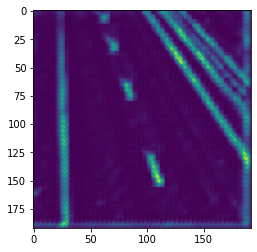

In [ ]:
if(len(prediction.shape)==4):
  plt.imshow(np.squeeze(prediction))
else:
  plt.imshow(prediction)

In [6]:
from tensorflow.keras.models import load_model
from IPython.display import clear_output
import numpy as np
from google.colab.patches import cv2_imshow
from skimage import img_as_ubyte
import cv2 as cv
model1=load_model('model.h5')

def roi(f):
    h=192
    w=192
    reg=np.array([[(0,h),(0,h//2),(w,h//2),(w,h)]],np.int32)
    maskx=np.zeros_like(f)
    cv.fillPoly(maskx,reg,255)
    img=cv.bitwise_and(f,maskx)
    return img

def houghlin(f,c):
    ope=cv.morphologyEx(c,cv.MORPH_OPEN,(5,5))
    dil=cv.dilate(ope,(5,5))
    er=cv.erode(dil,(5,5))
    lines = cv.HoughLinesP(er,2,np.pi/180,20,minLineLength=100,maxLineGap=15)
    if lines is not None:
        for i in range(0,lines.shape[0]):
            for x1,y1,x2,y2 in lines[i]:
                cv.line(f,(x1,y1),(x2,y2),(0,255,0),5)
    return f

cap=cv.VideoCapture("lane_vgt.mp4")
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv.resize(frame, (192, 192))
    frame = cv.copyMakeBorder(frame, 0, 0, 0, 0, cv.BORDER_CONSTANT, value=(0, 0, 0))
    frame = frame / 255
    frame = cv.resize(frame, (192, 192))
    frame = np.array(frame)
    frame1 = frame[None,:, :, :]
    mask1 = model1.predict(frame1)
    rem = np.resize(mask1, (192, 192))
    rem=np.round(rem)
    rem = rem * 255
    #crop=roi(rem)
    crop=roi(rem)
    cv2_imshow(rem)
    clear_output(wait=True)
    if cv.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv.destroyAllWindows()

KeyboardInterrupt: ignored